In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn import preprocessing, svm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import statsmodels.tsa.api as smt
import pickle

In [17]:
series = pd.read_excel('LMO.xlsx')
komparator = pd.read_excel('NMC.xlsx')
data = series

In [18]:
jumlah_cycle = 50

In [19]:
data['capacity_diff'] = data['Capacity'].diff()
data = data.dropna()

In [20]:
#Lakukan ADF Test

dt_data = data.set_index('Cycle').drop('Capacity', axis=1)
dt_data.dropna(axis=0)
    
smt.stattools.adfuller(dt_data['capacity_diff'], regression = 'ct')

(16974302048.59549,
 1.0,
 0,
 528,
 {'1%': -3.976018905537762,
  '5%': -3.4188378719568053,
  '10%': -3.1319612007373583},
 -30507.00226972034)

In [6]:
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1,7):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['capacity_diff'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    
    #supervised_df.to_csv('../data/model_df.csv', index=False)
    
    return supervised_df

In [7]:
def inisiasi(cyclesum, skenario):

    real = pd.read_excel(f'Data Degradasi {cyclesum} Cycle Skenario {skenario}.xlsx')
    real = real.drop('Cycle', axis = 1)
    model_df['Real'] = real

In [8]:
def grafik_raw(cycle_amount):

    fig, ax = plt.subplots(figsize=(15,7))

    sns.lineplot(alldata1.index[:cycle_amount], alldata1['Data Awal'][:cycle_amount], data=alldata1, ax=ax, 
                 label='Kapasitas Awal Skenario 1', color='mediumblue')
    frc1 = sns.lineplot(alldata1.index[cycle_amount:], alldata1['Prediksi Skenario 1'][cycle_amount:], data=alldata1, ax=ax, 
                 label='Prediksi Skenario 1', color='mediumblue')
    frc1.lines[1].set_linestyle("--")

    sns.lineplot(alldata2.index[:cycle_amount], alldata2['Data Awal'][:cycle_amount], data=alldata2, ax=ax, 
                 label='Kapasitas Awal Skenario 2', color='green')
    frc2 = sns.lineplot(alldata2.index[cycle_amount:], alldata2['Prediksi Skenario 2'][cycle_amount:], data=alldata2, ax=ax, 
                 label='Prediksi Skenario 2', color='green', dashes = False)
    frc2.lines[3].set_linestyle("--")

    sns.lineplot(alldata3.index[:cycle_amount], alldata3['Data Awal'][:cycle_amount], data=alldata3, ax=ax, 
                 label='Kapasitas Awal Skenario 3', color='red')
    frc3 = sns.lineplot(alldata3.index[cycle_amount:], alldata3['Prediksi Skenario 3'][cycle_amount:], data=alldata3, ax=ax, 
                 label='Prediksi Skenario 3', color='red', dashes = False )
    frc3.lines[5].set_linestyle("-.")
    
    #sns.lineplot(series.index, series['Capacity'], data=series, ax=ax, 
    #         label='Data Baterai LFP', color='black')
    
    ax.set(xlabel = "Siklus",
           ylabel = "Kapasitas",
           title = f"Prediksi Kapasitas {jumlah_cycle} Siklus Awal, Kernel Polinomial, LiFePO4 1C Discharging")
    
    ax.legend()
    
    sns.despine()

In [ ]:
#Compile algoritma di bawah setiap kali selesai bikin DataFrame

In [21]:
model_df = generate_supervised(data)
inisiasi(jumlah_cycle, 3)               #Masukin skenario yang mau di predict

X = np.array(model_df.drop(columns = ['Real'], axis = 1))
X = preprocessing.scale(X)
X_lately = X[jumlah_cycle:]
X = X[:jumlah_cycle]
model_df.dropna(inplace=True)
y = np.array(model_df['Real'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rs = GridSearchCV(svm.SVR(),
        {
            'C': [0.1, 1, 100, 1000],
            'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
            'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
        },
        cv=5, return_train_score=False)
rres_svr = rs.fit(X, y)
best_params_svr = rres_svr.best_params_
    
regm = svm.SVR(kernel='linear',       #Tentukan kernel
            C=best_params_svr['C'],
            epsilon=best_params_svr['epsilon'],
            gamma=best_params_svr['gamma'])
    
regm.fit(X_train, y_train)
    
forecast_set = regm.predict(X_lately)

mse = mean_squared_error(forecast_set, komparator['capacity'][jumlah_cycle:(jumlah_cycle+forecast_set.shape[0])])
rmse = np.sqrt(mse)
mae = mean_absolute_error(forecast_set, komparator['capacity'][jumlah_cycle:(jumlah_cycle+forecast_set.shape[0])])
r2 = r2_score(forecast_set, komparator['capacity'][jumlah_cycle:(jumlah_cycle+forecast_set.shape[0])])

In [136]:
rmse, mae, r2

(84.66510052586405, 40.17148333371823, -0.21814128270203148)

In [21]:
forecast_set.shape[0]

473

In [ ]:
### Kalo udah selesai nge-predict, pilih salah satu dari 3 line di bawah ini buat bikin DataFrame data Prediksi

In [10]:
forecast_linear_1 = pd.DataFrame(forecast_set, columns = ['Prediksi Skenario 1'])
alldata1 = pd.concat([model_df['Real'].dropna(), forecast_linear_1], ignore_index=True)
alldata1.rename(columns = {0:'Data Awal'}, inplace = True)

In [16]:
forecast_linear_2 = pd.DataFrame(forecast_set, columns = ['Prediksi Skenario 2'])
alldata2 = pd.concat([model_df['Real'].dropna(), forecast_linear_2], ignore_index=True)
alldata2.rename(columns = {0:'Data Awal'}, inplace = True)

In [22]:
forecast_linear_3 = pd.DataFrame(forecast_set, columns = ['Prediksi Skenario 3'])
alldata3 = pd.concat([model_df['Real'].dropna(), forecast_linear_3], ignore_index=True)
alldata3.rename(columns = {0:'Data Awal'}, inplace = True)

Text(0.5, 0, 'Siklus')

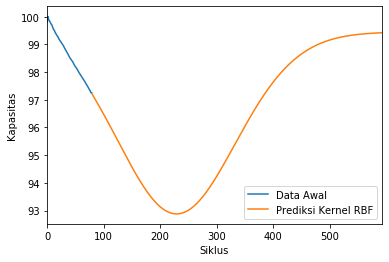

In [49]:
alldata3.plot()
plt.ylabel('Kapasitas')
plt.xlabel('Siklus')

In [ ]:
### Jangan compile sebelum 3 skenario selesai di predict

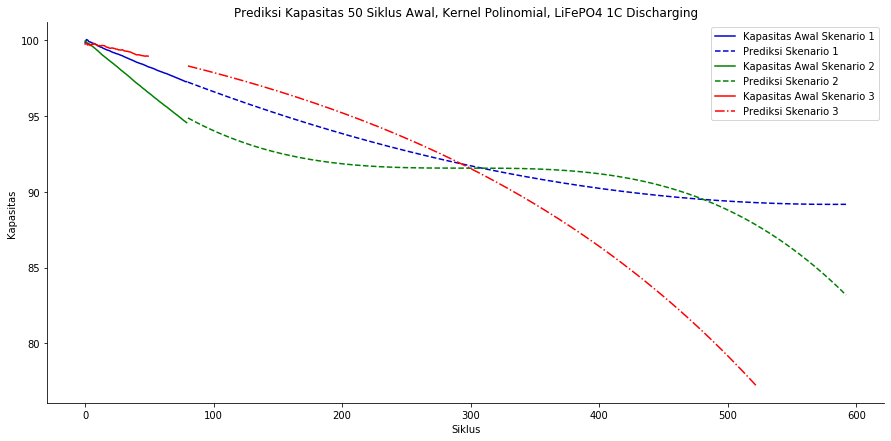

In [27]:
grafik_raw(80)

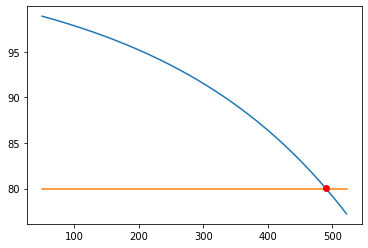

In [28]:
x = np.array(alldata3.index[50:])

# Grafik yang berhasil memotong garis degradasi JANGAN di-comment
# f1 berarti skenario 1, f2 skenario 2, f3 skenario 3
# g merupakan garis batas degradasi di nilai 80%

#f1 = np.array(alldata1['Prediksi Skenario 1'][jumlah_cycle:])
#f2 = np.array(alldata2['Prediksi Skenario 2'][jumlah_cycle:])
f3 = np.array(alldata3['Prediksi Skenario 3'][50:])
g = np.full((len(alldata3.index[jumlah_cycle:])), 80)


#plt.plot(x, f1, '-')
#plt.plot(x, f2, '-')
plt.plot(x, f3, '-')
plt.plot(x, g, '-')

#idx mengindikasikan titik perpotongan antara kurva degradasi dengan garis g
#idx1 untuk skenario 1, etc.. apabila skenario TIDAK memotong garis g, berikan '#'

#idx1 = np.argwhere(np.diff(np.sign(f1 - g))).flatten()
#idx2 = np.argwhere(np.diff(np.sign(f2 - g))).flatten()
idx3 = np.argwhere(np.diff(np.sign(f3 - g))).flatten()

plt.plot(x[idx3], f3[idx3], 'ro')
plt.show()

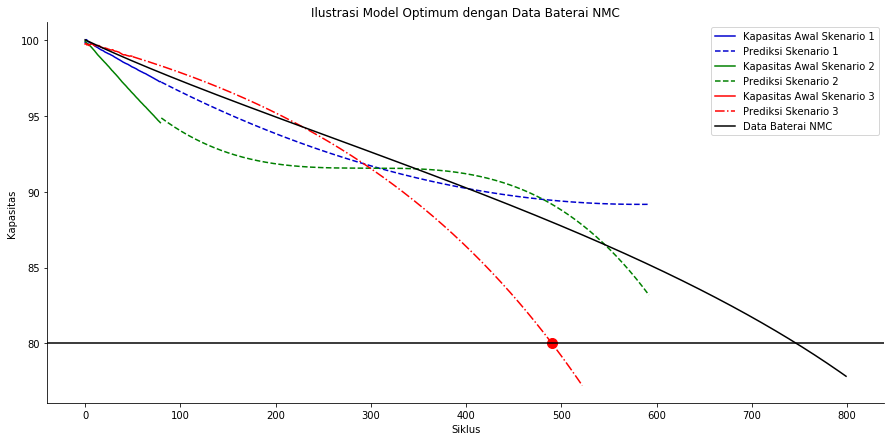

In [33]:
cycle_amount = 80

fig, ax = plt.subplots(figsize=(15,7))

sns.lineplot(alldata1.index[:cycle_amount], alldata1['Data Awal'][:cycle_amount], data=alldata1, ax=ax, 
                 label='Kapasitas Awal Skenario 1', color='mediumblue')
frc1 = sns.lineplot(alldata1.index[cycle_amount:], alldata1['Prediksi Skenario 1'][cycle_amount:], data=alldata1, ax=ax, 
                 label='Prediksi Skenario 1', color='mediumblue')
frc1.lines[1].set_linestyle("--")

sns.lineplot(alldata2.index[:cycle_amount], alldata2['Data Awal'][:cycle_amount], data=alldata2, ax=ax, 
                 label='Kapasitas Awal Skenario 2', color='green')
frc2 = sns.lineplot(alldata2.index[cycle_amount:], alldata2['Prediksi Skenario 2'][cycle_amount:], data=alldata2, ax=ax, 
                 label='Prediksi Skenario 2', color='green', dashes = False)
frc2.lines[3].set_linestyle("--")

sns.lineplot(alldata3.index[:50], alldata3['Data Awal'][:50], data=alldata3, ax=ax, 
                 label='Kapasitas Awal Skenario 3', color='red')
frc3 = sns.lineplot(alldata3.index[50:], alldata3['Prediksi Skenario 3'][50:], data=alldata3, ax=ax, 
                 label='Prediksi Skenario 3', color='red', dashes = False )
frc3.lines[5].set_linestyle("-.")

sns.lineplot(komparator.index, komparator['capacity'], data=komparator, ax=ax, 
             label='Data Baterai NMC', color='black')


#Atur batas degradasinya    

frc1.axhline(80, ls='-', color = 'black')           

#Pilih grafik skenario berapa yang mau ditampilin titik perpotongannya

#plt.scatter(idx1+jumlah_cycle, 80, marker='o', s=100, c = 'blue')
#plt.scatter(idx2+jumlah_cycle, 80, marker='o', s=100, c = 'green')
plt.scatter(idx3+50, 80, marker='o', s=100, c = 'red')

    
ax.set(xlabel = "Siklus",
       ylabel = "Kapasitas",
       title = "Ilustrasi Model Optimum dengan Data Baterai NMC")
    
ax.legend()
    
sns.despine()

#plt.savefig("Capacity Forecasting 50 Cycle, Kernel Linear, LMO 1C Discharging.png")